# Task 1: Implement SAGA Method

Start with simple NN, and small dataset

SAGA stores the gradient for all examples on running, a good start maybe zero or true gradient at initial weights

 Make sure to update the average model cheaply, by remmebring that every time only one functions (entry) gradient changes


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Task 1: SAGA Implementation

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

# SAGA optimizer
class SAGAOptimizer(optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(SAGAOptimizer, self).__init__(params, defaults)
        self.stored_gradients = {}
        self.avg_gradients = {}
        for group in self.param_groups:
            for p in group['params']:
                self.stored_gradients[p] = torch.zeros_like(p.data)
                self.avg_gradients[p] = torch.zeros_like(p.data)

    def step(self, closure=None):
        loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                if len(p.shape) == 1:  # Bias term
                    self.avg_gradients[p] += (grad - self.stored_gradients[p]) / len(grad)
                    self.stored_gradients[p] = grad.clone()
                    p.data -= group['lr'] * self.avg_gradients[p]
                else:  # Weight term
                    idx = torch.randint(0, p.grad.shape[0], (1,)).item()
                    self.avg_gradients[p][idx] += (grad[idx] - self.stored_gradients[p][idx]) / grad.shape[1]
                    self.stored_gradients[p][idx] = grad[idx].clone()
                    p.data[idx] -= group['lr'] * self.avg_gradients[p][idx]

        return loss.item()



# Example usage:

# Model, loss function and data
model = SimpleNN(10, 1)
mse_loss = nn.MSELoss()
x_train = torch.randn(100, 10)
y_train = torch.randn(100, 1)

# SAGA training
optimizer_saga = SAGAOptimizer(model.parameters(), lr=0.01)
for epoch in range(10):
    def closure():
        optimizer_saga.zero_grad()
        output = model(x_train)
        loss = mse_loss(output, y_train)
        loss.backward()
        return loss
    loss = optimizer_saga.step(closure)
    print(f"Epoch {epoch + 1}, Loss: {loss}")




Epoch 1, Loss: 1.4149644374847412
Epoch 2, Loss: 1.4128705263137817
Epoch 3, Loss: 1.4107882976531982
Epoch 4, Loss: 1.408718228340149
Epoch 5, Loss: 1.4066601991653442
Epoch 6, Loss: 1.4046131372451782
Epoch 7, Loss: 1.4025782346725464
Epoch 8, Loss: 1.4005545377731323
Epoch 9, Loss: 1.3985419273376465
Epoch 10, Loss: 1.3965404033660889


# Task 2: Implement SVRG
 Using the same model in task 1 , and small dataset.

 Plot the stochastic gradient variance, and the SVRG gradient variance

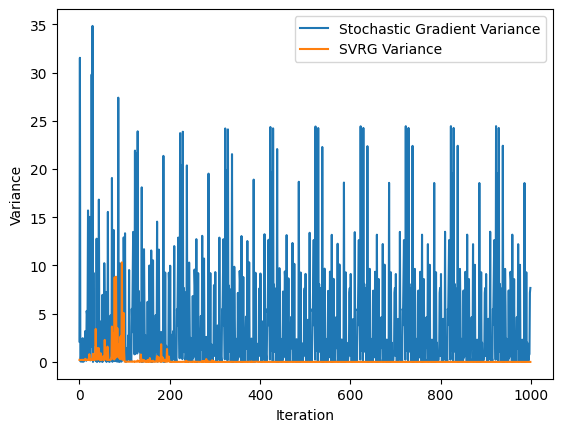

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class SVRGOptimizer:
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
        self.full_gradient = None
        self.snapshot = None

    def compute_full_gradient(self, x, y):
        self.model.zero_grad()
        predictions = self.model(x)
        loss = F.mse_loss(predictions, y)
        loss.backward()
        self.full_gradient = self.model.fc.weight.grad.clone()

    def take_snapshot(self):
        self.snapshot = self.model.fc.weight.clone()

    def step(self, x, y):
        # Stochastic gradient using current model parameters
        self.model.zero_grad()
        predictions = self.model(x)
        loss = F.mse_loss(predictions, y)
        loss.backward()
        current_gradient = self.model.fc.weight.grad.clone()

        # Stochastic gradient using the snapshot parameters
        self.model.zero_grad()
        with torch.no_grad():
            current_weights = self.model.fc.weight.clone()
            self.model.fc.weight = torch.nn.Parameter(self.snapshot)
        predictions = self.model(x)
        loss = F.mse_loss(predictions, y)
        loss.backward()
        snapshot_gradient = self.model.fc.weight.grad.clone()
        with torch.no_grad():
            self.model.fc.weight = torch.nn.Parameter(current_weights)

        # Variance-reduced gradient
        vr_gradient = current_gradient - snapshot_gradient + self.full_gradient

        # Update weights
        with torch.no_grad():
            self.model.fc.weight -= self.lr * vr_gradient

        stoch_var = torch.var(current_gradient)
        svrg_var = torch.var(vr_gradient)

        return stoch_var.item(), svrg_var.item()





# Initialize the neural network and optimizer
nn_model = SimpleNN(10, 1)
optimizer = SVRGOptimizer(nn_model, lr=0.01)

# Create synthetic data
x_train = torch.randn(100, 10, requires_grad=True)
y_train = torch.randn(100, 1, requires_grad=True)

stoch_vars, svrg_vars = [], []

for epoch in range(num_epochs):
    optimizer.compute_full_gradient(x_train, y_train)
    optimizer.take_snapshot()
    for x, y in zip(x_train, y_train):
        stoch_var, svrg_var = optimizer.step(x.unsqueeze(0), y.unsqueeze(0))
        stoch_vars.append(stoch_var)
        svrg_vars.append(svrg_var)

# Plotting the results
plt.plot(stoch_vars, label='Stochastic Gradient Variance')
plt.plot(svrg_vars, label='SVRG Variance')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.show()


# Task 3 : Try Federated Learning with SGD

Given any non-iid data across four clients, complete the training process by implementing the missing backward pass and optimizer step .

Additionally, explore different aggregation methods (e.g., FedAvg) and analyze the federated learning results, if you were told to use orthogonal dataset, which mean data from client i are (almost) orhtogonal to data from clinet j whever i is not j.

COmpare the results from different aggregation methods (at least 2)


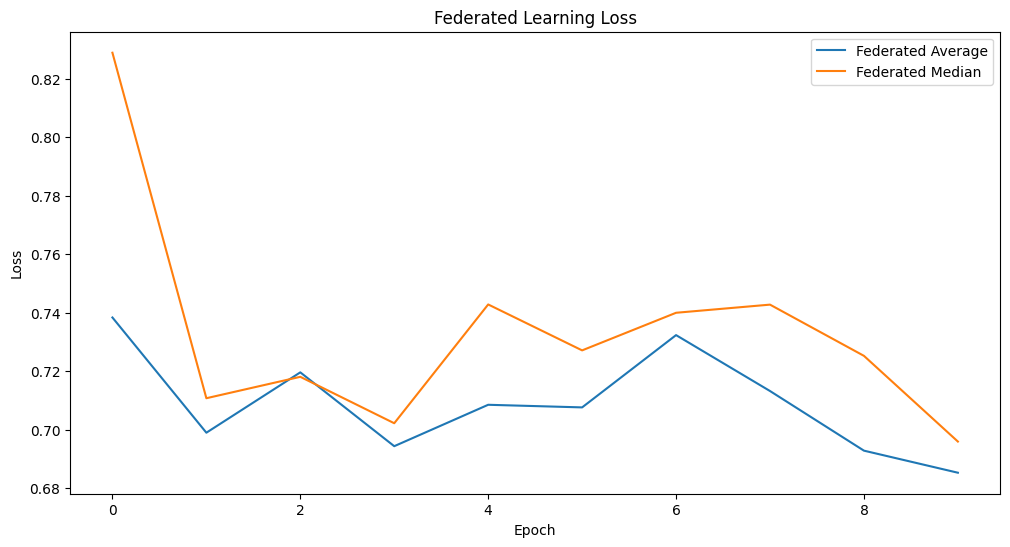

In [171]:


# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

num_data_points = 100
num_classes = 2
num_clients = 4
num_dimensions = 10  # Update to 10 dimensions
num_epochs = 10

# Example data, but you can use any dataset
def generate_non_iid_data(num_clients, num_data_points, num_classes, num_dimensions):
    data = []
    for client_id in range(num_clients):
        mean = torch.randn(num_dimensions)
        std_dev = 0.2 + 0.1 * torch.randn(num_dimensions)
        client_data = torch.randn(num_data_points, num_dimensions) * std_dev + mean
        labels = torch.randint(0, num_classes, (num_data_points,))
        data.append((client_data, labels))
    return data

client_data = generate_non_iid_data(num_clients, num_data_points, num_classes, num_dimensions)

class SimpleModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Initialize the global model
global_model_average = SimpleModel(num_dimensions, num_classes)
global_model_median = SimpleModel(num_dimensions, num_classes)

# Define the aggregation methods (e.g., FedAvg, FedMed, FedSum)
def federated_average(models):
    avg_state_dict = {}
    for key in models[0].state_dict().keys():
        avg_state_dict[key] = torch.mean(torch.stack([model.state_dict()[key] for model in models]), dim=0)
    return avg_state_dict


def federated_median(models):
    med_state_dict = {}
    for key in models[0].state_dict().keys():
        med_state_dict[key] = torch.median(torch.stack([model.state_dict()[key] for model in models]), dim=0).values
    return med_state_dict


# Federated training loop
global_losses_average = []
global_losses_median = []

for epoch in range(num_epochs):
    local_models = []
    local_losses = []

    for client_id in range(num_clients):
        client_model = SimpleModel(num_dimensions, num_classes)
        optimizer = optim.SGD(client_model.parameters(), lr=0.01)
        data, labels = client_data[client_id]

        for _ in range(num_epochs):
            optimizer.zero_grad()
            outputs = client_model(data)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()  # compute gradients
            optimizer.step()  # update model parameters

            local_losses.append(loss.item())

        local_models.append(client_model)

    # Aggregate the local models using federated averaging
    global_model_average.load_state_dict(federated_average(local_models))

    global_model_median.load_state_dict(federated_median(local_models))

    # average
    global_outputs_average = []
    global_labels_average = []
    for data, labels in client_data:
        global_outputs_average.append(global_model_average(data))
        global_labels_average.append(labels)

    global_outputs_average = torch.cat(global_outputs_average)
    global_labels_average = torch.cat(global_labels_average)

    global_loss = nn.CrossEntropyLoss()(global_outputs_average, global_labels_average)
    global_losses_average.append(global_loss.item())

    # median
    global_outputs_median = []
    global_labels_median = []
    for data, labels in client_data:
        global_outputs_median.append(global_model_median(data))
        global_labels_median.append(labels)

    global_outputs_median = torch.cat(global_outputs_median)
    global_labels_median = torch.cat(global_labels_median)

    global_loss = nn.CrossEntropyLoss()(global_outputs_median, global_labels_median)
    global_losses_median.append(global_loss.item())

# Plot the global loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(global_losses_average, label='Federated Average')
plt.plot(global_losses_median, label='Federated Median')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Federated Learning Loss')
plt.legend()
plt.show()



